In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Castelo BFS") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .getOrCreate()

from graphframes import GraphFrame

In [4]:
salas = spark.createDataFrame([
    ("sala1", "Entrada"),
    ("sala2", "Salão Principal"),
    ("sala3", "Sala de Armas"),
    ("sala4", "Biblioteca"),
    ("sala5", "Cozinha"),
    ("sala6", "Jardim"),
    ("sala7", "Torre"),
    ("sala8", "Masmorras"),
    ("sala9", "Quarto Secreto"),
    ("sala10", "Saída")
], ["id", "nome"])

In [5]:
portas = spark.createDataFrame([
    ("sala1", "sala2"),
    ("sala2", "sala3"),
    ("sala2", "sala4"),
    ("sala3", "sala5"),
    ("sala4", "sala5"),
    ("sala5", "sala6"),
    ("sala6", "sala10"),
    ("sala3", "sala7"),
    ("sala7", "sala8"),
    ("sala8", "sala9"),
    ("sala9", "sala10")
], ["src", "dst"])

In [7]:
castelo = GraphFrame(salas,portas)

/tmp/ipykernel_9355/634492116.py:23: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(nx_graph, pos, arrowstyle='->', arrowsize=20)


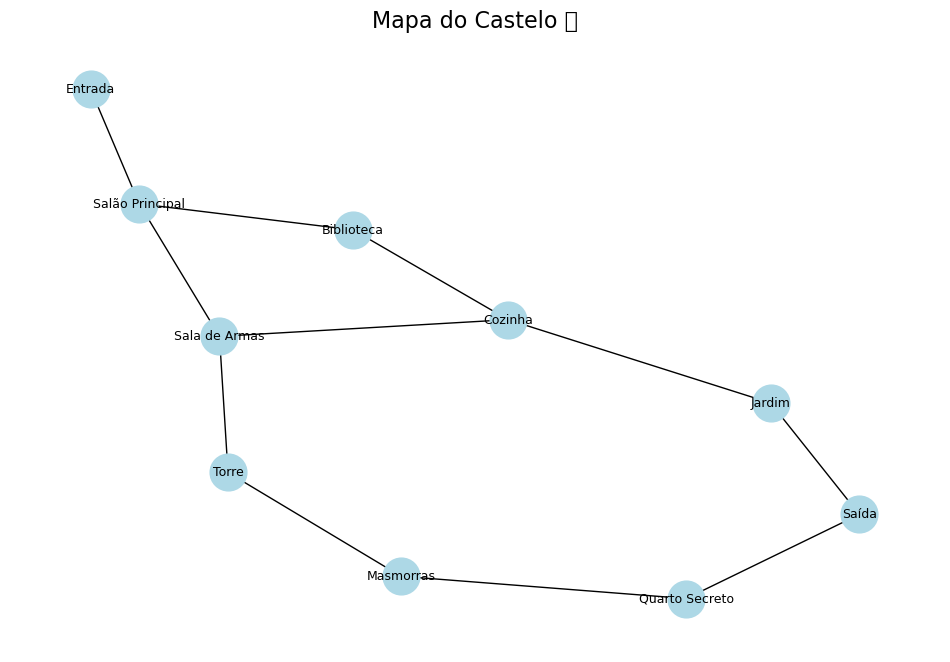

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Coletar as arestas
edges_list = castelo.edges.select("src", "dst").rdd.map(lambda row: (row.src, row.dst)).collect()

# Coletar os nomes das salas
vertices_names = castelo.vertices.select("id", "nome").rdd.map(lambda row: (row.id, row.nome)).collect()
id_to_name = dict(vertices_names)

# Criar grafo NetworkX
nx_graph = nx.Graph()
nx_graph.add_edges_from(edges_list)

# Layout
pos = nx.spring_layout(nx_graph, seed=42)

# Desenhar nós
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(nx_graph, pos, node_color='lightblue', node_size=700)

# Desenhar arestas
nx.draw_networkx_edges(nx_graph, pos, arrowstyle='->', arrowsize=20)

# Desenhar labels (nomes das salas)
labels = {node: id_to_name.get(node, node) for node in nx_graph.nodes()}
nx.draw_networkx_labels(nx_graph, pos, labels, font_size=9)

plt.title("Mapa do Castelo 🏰", fontsize=16)
plt.axis('off')
plt.show()

In [10]:
caminho_para_saida = castelo.bfs(
    fromExpr="id = 'sala1'",
    toExpr="id = 'sala10'"
)

In [11]:
caminho_para_saida.show()

+----------------+--------------+--------------------+--------------+--------------------+--------------+----------------+--------------+---------------+---------------+---------------+
|            from|            e0|                  v1|            e1|                  v2|            e2|              v3|            e3|             v4|             e4|             to|
+----------------+--------------+--------------------+--------------+--------------------+--------------+----------------+--------------+---------------+---------------+---------------+
|{sala1, Entrada}|{sala1, sala2}|{sala2, Salão Pri...|{sala2, sala4}| {sala4, Biblioteca}|{sala4, sala5}|{sala5, Cozinha}|{sala5, sala6}|{sala6, Jardim}|{sala6, sala10}|{sala10, Saída}|
|{sala1, Entrada}|{sala1, sala2}|{sala2, Salão Pri...|{sala2, sala3}|{sala3, Sala de A...|{sala3, sala5}|{sala5, Cozinha}|{sala5, sala6}|{sala6, Jardim}|{sala6, sala10}|{sala10, Saída}|
+----------------+--------------+--------------------+--------------+-

In [16]:
caminho_para_saida = castelo.bfs(
    fromExpr="id = 'sala1'",
    toExpr="id = 'sala10'",
    maxPathLength=10
)

In [17]:
caminho_para_saida.show()

+----------------+--------------+--------------------+--------------+--------------------+--------------+----------------+--------------+---------------+---------------+---------------+
|            from|            e0|                  v1|            e1|                  v2|            e2|              v3|            e3|             v4|             e4|             to|
+----------------+--------------+--------------------+--------------+--------------------+--------------+----------------+--------------+---------------+---------------+---------------+
|{sala1, Entrada}|{sala1, sala2}|{sala2, Salão Pri...|{sala2, sala4}| {sala4, Biblioteca}|{sala4, sala5}|{sala5, Cozinha}|{sala5, sala6}|{sala6, Jardim}|{sala6, sala10}|{sala10, Saída}|
|{sala1, Entrada}|{sala1, sala2}|{sala2, Salão Pri...|{sala2, sala3}|{sala3, Sala de A...|{sala3, sala5}|{sala5, Cozinha}|{sala5, sala6}|{sala6, Jardim}|{sala6, sala10}|{sala10, Saída}|
+----------------+--------------+--------------------+--------------+-

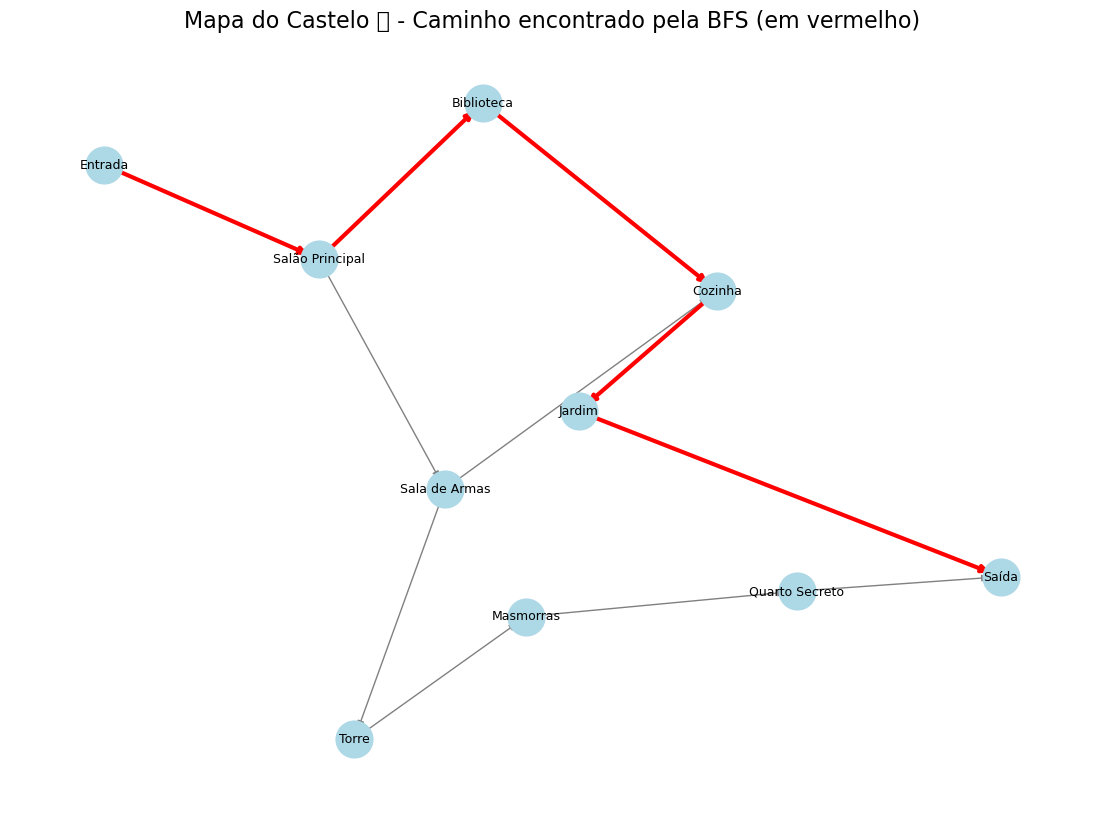

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Coletar arestas para NetworkX
edges_list = castelo.edges.select("src", "dst").rdd.map(lambda row: (row.src, row.dst)).collect()

# Coletar nomes dos vértices
vertices_names = castelo.vertices.select("id", "nome").rdd.map(lambda row: (row.id, row.nome)).collect()
id_to_name = dict(vertices_names)

# Criar grafo NetworkX
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(edges_list)

# Rodar BFS para pegar o caminho
bfs_result = castelo.bfs(
    fromExpr="id = 'sala1'",
    toExpr="id = 'sala10'"
)

# Coletar caminho encontrado
bfs_row = bfs_result.first().asDict()

# Extrair sequência de arestas do caminho
caminho_bfs = []
for i in range(len(bfs_row) // 2):
    try:
        src = bfs_row[f"e{i}"]["src"]
        dst = bfs_row[f"e{i}"]["dst"]
        caminho_bfs.append((src, dst))
    except KeyError:
        break  # Se não existir e{i}, terminou

# Layout dos nós
pos = nx.spring_layout(nx_graph, seed=42)

# Desenhar nós
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(nx_graph, pos, node_color='lightblue', node_size=700)

# Desenhar todas arestas (cinza claro)
nx.draw_networkx_edges(nx_graph, pos, edgelist=edges_list, edge_color='gray', arrows=True)

# Desenhar arestas do caminho BFS (vermelho e mais grosso)
nx.draw_networkx_edges(nx_graph, pos, edgelist=caminho_bfs, edge_color='red', width=3, arrows=True)

# Desenhar labels (nomes das salas)
labels = {node: id_to_name.get(node, node) for node in nx_graph.nodes()}
nx.draw_networkx_labels(nx_graph, pos, labels, font_size=9)

plt.title("Mapa do Castelo 🏰 - Caminho encontrado pela BFS (em vermelho)", fontsize=16)
plt.axis('off')
plt.show()